# Lithium prescribing trends in England. 

## **Background and Rationale**
For over 60 years lithium has been the gold standard for the treatment and prevention of relapse in bipolar disorder.  In recent years, published literature has confirmed the superiority of lithium in this field, including two meta-analysis of RCTs (Severus et al. 2014, Miura et al. 2014) and one of observational studies (Kessing et al 2018).  Yet in various countries, authors have described a decline in lithium use (Karanti et al. 2016), including in the UK (Hayes et al. 2011, Lyall et al. 2019).  We wish to use NHS prescription data to describe long term lithium prescribing trends in England.  

In 2016, NICE recommended that lithium be used first line in the prevention of relapse in bipolar disorder.  We aim to explore if this recommendation changed prescribing practice.  Furthermore, we would like to see if there are national variations in the use of lithium, as previous authors have suggested (POMH Lithium report, 2008). 

## **Proposed project**
### Title:  
Lithium prescribing trends
### Description:  
* Total number of items of lithium dispensed each year from 1998 to 2018
* Total number of lithium items per 1000 patient population for each CCG with comparison of 2015 data to 2018 data.
* Total number of hospital prescriptions for lithium dispensed at sample timepoints
* Total number of lithium patients registered in GPs as determined by QOF data
* Total number of DDDs of lithium dispensed each year from 2010 to 2019 



In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

### Print graph of lithium use from 1998 to 2018 using PCA data

In [2]:
sql = """
SELECT
drug_name,
Chemical_code_current,
year,
items

FROM ebmdatalab.helen.trends_from_pca_final_2018new

WHERE (Chemical_code_current = "0402030K0" OR Chemical_code_current = "0402030P0")

GROUP BY
year,
drug_name,
Chemical_code_current,
items

ORDER BY
year


"""

df_lithium_pca = bq.cached_read(sql, csv_path = 'lithium_pca.csv')

In [3]:
df_lithium_pca.head(21)

,drug_name,Chemical_code_current,year,items
0,Lithium Carb_Tab Slow 400mg,0402030K0,1998,100.0
1,Camcolit 250_Tab 250mg,0402030K0,1998,42300.0
2,Camcolit 400_Tab 400mg,0402030K0,1998,32600.0
3,Liskonum_Tab 450mg,0402030K0,1998,7800.0
4,Priadel_Tab 400mg,0402030K0,1998,396700.0
5,Priadel 200_Tab 200mg,0402030K0,1998,180000.0
6,Lithonate_Tab 400mg,0402030K0,1998,5700.0
7,Litarex_Tab 564mg,0402030P0,1998,2700.0
8,Priadel_Liq 520mg/5ml S/F,0402030P0,1998,8300.0
9,Li-Liquid_Syr 10.8mmol/5ml,0402030P0,1998,600.0


In [4]:
df_lithium_pca_totalcount = df_lithium_pca.groupby(['year'], as_index=False).sum()
df_lithium_pca_totalcount.head(21)

,year,items
0,1998,677500.0
1,1999,694500.0
2,2000,714495.0
3,2001,738647.0
4,2002,752838.0
5,2003,765062.0
6,2004,780240.0
7,2005,786166.0
8,2006,793642.0
9,2007,810086.0


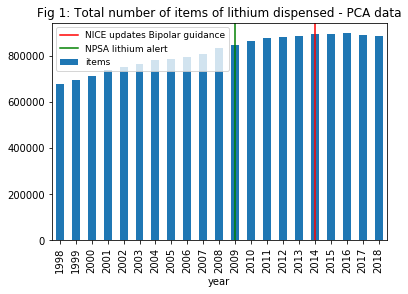

In [5]:
plot1 = df_lithium_pca.groupby("year").sum().plot(kind='bar', title="Fig 1: Total number of items of lithium dispensed - PCA data")

#add in timeline to show date of NPSA publication and date of NICE publication of Bipolar guidance.
plot1.axvline(x=16, color='r',linestyle='-', label='NICE updates Bipolar guidance')
plot1.axvline(x=11, color='g', linestyle='-', label='NPSA lithium alert')
plot1.legend(loc=2, prop={'size': 9})

## Describe total lithium dispensed using monthly practice level data from 2010 to 2019

In [6]:
sql2 = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
rx.practice,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "0402030K0%", items,0)) AS carbonate,
sum(IF(rx.bnf_code LIKE "0402030P0%", items,0)) AS citrate,
sum(items) AS total_lithium,
sum(actual_cost) AS total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practices AS prac
ON
rx.practice = prac.code 
JOIN
  hscic.ccgs AS ccgs
ON
rx.pct=ccgs.code
WHERE
  prac.setting = 4
  AND (bnf_code LIKE "0402030K0%" OR ##carbonate
  bnf_code LIKE "0402030P0%") ##citrate
  AND ccgs.org_type='CCG'
  AND month <= '2019-12-01'
GROUP BY
rx.month,
rx.practice,
rx.pct,
chemical_code,
chemical
ORDER BY
month"""

df_lithium = bq.cached_read(sql2, csv_path='lithium.csv')

Downloading: 100%|██████████| 825717/825717 [01:11<00:00, 11503.52rows/s]


In [7]:
df_lithium['month'] = df_lithium['month'].astype('datetime64[ns]')
df_lithium.head(-20)

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,H82016,70F,0402030K0,Lithium carbonate,11,0,11,11.52000
1,2010-08-01,P89014,01Y,0402030K0,Lithium carbonate,41,0,41,30.81000
2,2010-08-01,D83080,06L,0402030K0,Lithium carbonate,3,0,3,6.23000
3,2010-08-01,L83007,15N,0402030K0,Lithium carbonate,2,0,2,3.52000
4,2010-08-01,P81076,00X,0402030K0,Lithium carbonate,22,0,22,19.12000
...,...,...,...,...,...,...,...,...,...
825692,2019-12-01,E83044,93C,0402030K0,Lithium carbonate,6,0,6,9.10508
825693,2019-12-01,P86619,01D,0402030K0,Lithium carbonate,5,0,5,11.09338
825694,2019-12-01,F81025,99E,0402030K0,Lithium carbonate,1,0,1,4.42534
825695,2019-12-01,A83006,16C,0402030K0,Lithium carbonate,24,0,24,21.55965


In [8]:
df_lithium["chemical"].unique()#shows me the unique values within the chemical column

array(['Lithium carbonate', 'Lithium citrate'], dtype=object)

In [10]:
df_lithium.nunique()#counts the number of unique items in each column.  

month               113
practice           8022
pct                 135
chemical_code         2
chemical              2
carbonate           139
citrate              35
total_lithium       138
total_cost       210301
dtype: int64

In [11]:
df_carbonate = df_lithium.loc[df_lithium["chemical"] == "Lithium carbonate"]
df_carbonate.head()#shows me the data for Lithium Carbonate

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,H82016,70F,0402030K0,Lithium carbonate,11,0,11,11.52
1,2010-08-01,P89014,01Y,0402030K0,Lithium carbonate,41,0,41,30.81
2,2010-08-01,D83080,06L,0402030K0,Lithium carbonate,3,0,3,6.23
3,2010-08-01,L83007,15N,0402030K0,Lithium carbonate,2,0,2,3.52
4,2010-08-01,P81076,00X,0402030K0,Lithium carbonate,22,0,22,19.12


In [12]:
df_citrate = df_lithium.loc[df_lithium["chemical"] == "Lithium citrate"]
df_citrate.head()#shows me the data for Lithium Citrate

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
41,2010-08-01,C81086,15M,0402030P0,Lithium citrate,0,3,3,26.38
51,2010-08-01,L83043,15N,0402030P0,Lithium citrate,0,1,1,20.68
54,2010-08-01,C86013,02X,0402030P0,Lithium citrate,0,1,1,10.36
56,2010-08-01,H81082,10C,0402030P0,Lithium citrate,0,1,1,7.26
63,2010-08-01,G83001,72Q,0402030P0,Lithium citrate,0,1,1,42.66


In [13]:
ccg_lithium_totalcount = df_lithium.groupby(["month", "pct"], as_index=False).sum()
ccg_lithium_totalcount.tail()#shows me the data grouped by PCT, therefore representing CCGs

,month,pct,carbonate,citrate,total_lithium,total_cost
15250,2019-12-01,99C,428,2,430,1340.42814
15251,2019-12-01,99E,198,6,204,479.75234
15252,2019-12-01,99F,110,0,110,485.28093
15253,2019-12-01,99G,203,1,204,502.35758
15254,2019-12-01,99M,243,1,244,775.91080


In [14]:
ccg_lithium_totalcount.describe()

,carbonate,citrate,total_lithium,total_cost
count,15255.000000,15255.000000,15255.000000,15255.000000
mean,531.236185,5.379810,536.615995,984.952799
std,440.600130,6.025542,445.161018,915.162138
min,27.000000,0.000000,27.000000,49.340000
25%,227.000000,1.000000,229.000000,381.585555
50%,375.000000,3.000000,379.000000,657.410000
75%,669.000000,7.000000,675.000000,1236.987115
max,2147.000000,54.000000,2167.000000,6726.550000


### Display total no. of items dispensed per year

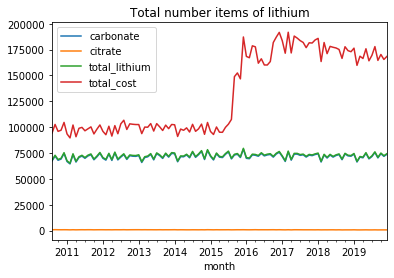

In [15]:
plot2 = df_lithium.groupby("month").sum().plot(kind='line', title="Total number items of lithium")

In [16]:
#calculate the average monthly no. of items of lithium
df_permonth = df_lithium.groupby('month').sum()
df_permonth.head()

,carbonate,citrate,total_lithium,total_cost
month,,,,
2010-08-01,67363,713,68076,94380.62
2010-09-01,71977,851,72828,102601.98
2010-10-01,67950,775,68725,95892.43
2010-11-01,69088,752,69840,97011.15
2010-12-01,74513,781,75294,104562.89


In [17]:
df_permonth['total_lithium'].mean()

72443.1592920354

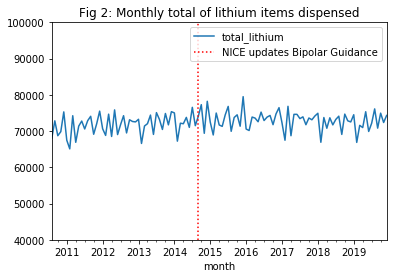

In [18]:
plot3 = df_lithium.groupby("month")['total_lithium'].sum().plot(kind='line', title="Fig 2: Monthly total of lithium items dispensed")
plt.ylim(40000, 100000) #shows just the item count. Increase in cost above due to increased cost of 250mg tablets in 2015/6

#add in timeline to show date of NICE publication of Bipolar guidance.
plot3.axvline('2014-09-01',color='r',linestyle=':', label='NICE updates Bipolar Guidance')
plot3.legend()

In [ ]:
## Check data by testing if annual sum of monthly practice level data is similar to annual PCA numbers
## 2011 data  
#mask1 = (df_lithium['month'] >= "2011-01-01") & (df_lithium['month'] <= "2011-12-31")
#df_annual2011 = df_lithium.loc[mask1]
#df_annual2011.sum()

In [ ]:
## 2012 data
#mask2 = (df_lithium['month'] >= "2012-01-01") & (df_lithium['month'] <= "2012-12-31")
#df_annual2012 = df_lithium.loc[mask2]
#df_annual2012.sum()

In [ ]:
## 2013 data
#mask3 = (df_lithium['month'] >= "2013-01-01") & (df_lithium['month'] <= "2013-12-31")
#df_annual2013 = df_lithium.loc[mask3]
#df_annual2013.sum()

In [ ]:
## 2014 data
#mask4 = (df_lithium['month'] >= "2014-01-01") & (df_lithium['month'] <= "2014-12-31")
#df_annual2014 = df_lithium.loc[mask4]
#df_annual2014.sum()

In [ ]:
## 2015 data
#mask5 = (df_lithium['month'] >= "2015-01-01") & (df_lithium['month'] <= "2015-12-31")
#df_annual2015 = df_lithium.loc[mask5]
#df_annual2015.sum()

In [ ]:
## 2016 data
#mask6 = (df_lithium['month'] >= "2016-01-01") & (df_lithium['month'] <= "2016-12-31")
#df_annual2016 = df_lithium.loc[mask6]
#df_annual2016.sum()

In [ ]:
## 2017 data
#mask7 = (df_lithium['month'] >= "2017-01-01") & (df_lithium['month'] <= "2017-12-31")
#df_annual2017 = df_lithium.loc[mask7]
#df_annual2017.sum()

### Describe no. of lithium items per 1000 patients in each CCG to show Geographical Variation

In [19]:
##get list size info.  removed pct_id AS pct and AVG(total_list_size) AS list_size
sql3 = """
SELECT month, 
practice, 
total_list_size

FROM ebmdatalab.hscic.practice_statistics_all_years

GROUP BY 
month, practice, total_list_size

ORDER BY
month, practice,
total_list_size
"""
df_list = bq.cached_read(sql3, csv_path='df_list.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(-20)

,month,practice,total_list_size
0,2010-10-01,A81001,4241
1,2010-10-01,A81002,20535
2,2010-10-01,A81003,3706
3,2010-10-01,A81004,8096
4,2010-10-01,A81005,7970
...,...,...,...
954359,2019-11-01,Y05318,6121
954360,2019-11-01,Y05330,3252
954361,2019-11-01,Y05346,3496
954362,2019-11-01,Y05349,4695


In [20]:
df_list.isnull().sum()#shows if we are missing data where PCT name is recorded as NaN


month              0
practice           0
total_list_size    0
dtype: int64

In [21]:
ccg_lithium_count = df_lithium.groupby(["month", "practice", "pct"])["total_lithium"].sum().reset_index()
ccg_lithium_count.head(-20)

,month,practice,pct,total_lithium
0,2010-08-01,A81001,16C,6
1,2010-08-01,A81002,16C,20
2,2010-08-01,A81004,16C,10
3,2010-08-01,A81005,16C,14
4,2010-08-01,A81006,16C,28
...,...,...,...,...
770433,2019-12-01,Y04977,15M,1
770434,2019-12-01,Y04995,15M,50
770435,2019-12-01,Y05023,06Q,7
770436,2019-12-01,Y05080,08E,5


In [22]:
#merge dataframes to add list size per practice

df_lithium_merged = pd.merge(ccg_lithium_count, df_list, on=['month', 'practice'])
df_lithium_merged.head()

,month,practice,pct,total_lithium,total_list_size
0,2010-10-01,A81001,16C,7,4241
1,2010-10-01,A81002,16C,21,20535
2,2010-10-01,A81004,16C,11,8096
3,2010-10-01,A81005,16C,15,7970
4,2010-10-01,A81006,16C,23,12309


In [23]:
#group data by PCT for each month
df_lithium_per1000 = df_lithium_merged.groupby(['month', 'pct']).sum().reset_index()
df_lithium_per1000.head()

,month,pct,total_lithium,total_list_size
0,2010-10-01,00L,588,320505
1,2010-10-01,00N,239,150479
2,2010-10-01,00P,535,272636
3,2010-10-01,00Q,224,141344
4,2010-10-01,00R,260,162673


In [24]:
#calculate no lithium items per 1000 patients 
df_lithium_per1000['items_per_1000'] = round(1000* (df_lithium_per1000['total_lithium']/df_lithium_per1000['total_list_size']),2)
df_lithium_per1000.head()

,month,pct,total_lithium,total_list_size,items_per_1000
0,2010-10-01,00L,588,320505,1.83
1,2010-10-01,00N,239,150479,1.59
2,2010-10-01,00P,535,272636,1.96
3,2010-10-01,00Q,224,141344,1.58
4,2010-10-01,00R,260,162673,1.60


In [25]:
df_lithium_per1000['month'] = df_lithium_per1000['month'].astype('datetime64[ns]')

In [27]:
df_lithium_per1000.describe()

,total_lithium,total_list_size,items_per_1000
count,14850.000000,1.485000e+04,14850.000000
mean,536.587003,4.013049e+05,1.315899
std,445.141016,3.184798e+05,0.461193
min,27.000000,7.550500e+04,0.320000
25%,229.000000,2.029560e+05,0.990000
50%,379.000000,2.791170e+05,1.230000
75%,675.000000,5.203780e+05,1.580000
max,2167.000000,1.872142e+06,3.430000


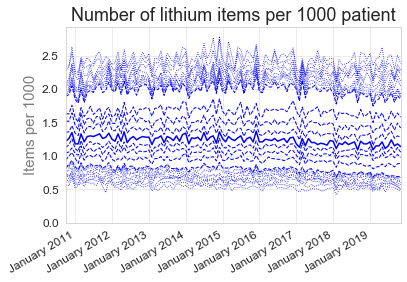

In [28]:
#create sample deciles

charts.deciles_chart(
        df_lithium_per1000,
        period_column='month',
        column='items_per_1000',
        title="Number of lithium items per 1000 patient",
        ylabel='Items per 1000',
        show_outer_percentiles=True,
        show_legend=False,
)

plt.show()

In [29]:
##Restrict to one month to create a map - January 2019
df_lithium_inJan19 = df_lithium_per1000.loc[(df_lithium_per1000['month'] == '2019-01-01')]
df_lithium_inJan19.head()

,month,pct,total_lithium,total_list_size,items_per_1000
13365,2019-01-01,00L,763,324089,2.35
13366,2019-01-01,00N,198,149923,1.32
13367,2019-01-01,00P,704,273485,2.57
13368,2019-01-01,00Q,228,164034,1.39
13369,2019-01-01,00R,246,168023,1.46


In [31]:
df_lithium_inJan19.loc[df_lithium_inJan19['pct']=='16C']

,month,pct,total_lithium,total_list_size,items_per_1000
13476,2019-01-01,16C,1107,687870,1.61


In [32]:
##Restrict to one month to create a map - Apr2019
df_lithium_inApr19 = df_lithium_per1000.loc[(df_lithium_per1000['month'] == '2019-04-01')]
df_lithium_inApr19.head()

,month,pct,total_lithium,total_list_size,items_per_1000
13770,2019-04-01,00L,711,322674,2.20
13771,2019-04-01,00N,237,154372,1.54
13772,2019-04-01,00P,676,267514,2.53
13773,2019-04-01,00Q,199,157624,1.26
13774,2019-04-01,00R,214,165875,1.29


In [33]:
df_lithium_inApr19.loc[df_lithium_inApr19['pct']=='15N']

,month,pct,total_lithium,total_list_size,items_per_1000
13880,2019-04-01,15N,1858,1221403,1.52


In [ ]:
#create choropeth map showing recent prescribing variation (Jan 2019)
#plt.figure(figsize=(12, 7))
#plt = maps.ccg_map(df_lithium_inJan19, title="Number of lithium item dispensed each month per 1000 patients per CCG in Jan 2019", map_year='2020', column='items_per_1000', separate_london=True)
#'cmap': "OrRd"
#plt.show()

In [48]:
#create choropeth map showing recent prescribing variation (Apr 2019)
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df_lithium_inApr19, title="Lithium use per 1000 patients per CCG in Apr 2019", map_year='2020', column='items_per_1000', separate_london=True)
plt.show()

BaseException: Data contains CCG codes we don't know about: ['16C' '18C' '26A' '27D' '36J' '36L' '42D' '52R' '70F' '71E' '72Q' '78H'
 '84H' '91Q' '92A' '92G' '93C' '97R']

<Figure size 864x504 with 0 Axes>

In [ ]:
#create choreopath map showing CCG prescribing variation just after NICE publication (Oct2014)
#suggested not to use this as choreopeth maps don't work for 2014 data.
#df_lithium_inOct14 = df_lithium_per1000.loc[(df_lithium_per1000['month'] == '2014-10-01')]
#plt.figure(figsize=(12, 7))
#plt = maps.ccg_map(df_lithium_inOct14, title="Lithium use per 1000 patients per CCG in Oct 2014", column='items_per_1000', separate_london=True)
#plt.show()

## Show change in CCG prescribing rates from 2010 to 2019

In [35]:
df_lithium_per1000.head()

,month,pct,total_lithium,total_list_size,items_per_1000
0,2010-10-01,00L,588,320505,1.83
1,2010-10-01,00N,239,150479,1.59
2,2010-10-01,00P,535,272636,1.96
3,2010-10-01,00Q,224,141344,1.58
4,2010-10-01,00R,260,162673,1.60


In [36]:
#choose the relevant columns of data that I need
columns = ['month', 'pct', 'items_per_1000']
df_lithium2 = df_lithium_per1000[columns].reset_index(drop=True)
df_lithium2.head()

,month,pct,items_per_1000
0,2010-10-01,00L,1.83
1,2010-10-01,00N,1.59
2,2010-10-01,00P,1.96
3,2010-10-01,00Q,1.58
4,2010-10-01,00R,1.60


In [37]:
#extract year from date time for each line
df_lithium2["year"] = df_lithium2['month'].dt.year

df_lithium2.head()

,month,pct,items_per_1000,year
0,2010-10-01,00L,1.83,2010
1,2010-10-01,00N,1.59,2010
2,2010-10-01,00P,1.96,2010
3,2010-10-01,00Q,1.58,2010
4,2010-10-01,00R,1.60,2010


In [44]:
df_lithium2.loc[df_lithium2['pct']=='15N'].head(-20)#shows an example of the data for one PCT '15N'

,month,pct,items_per_1000,year
110,2010-10-01,15N,1.59,2010
245,2010-11-01,15N,1.61,2010
380,2010-12-01,15N,1.69,2010
515,2011-01-01,15N,1.53,2011
650,2011-02-01,15N,1.48,2011
...,...,...,...,...
11585,2017-11-01,15N,1.56,2017
11720,2017-12-01,15N,1.64,2017
11855,2018-01-01,15N,1.64,2018
11990,2018-02-01,15N,1.49,2018


In [39]:
df_lithium2.groupby(["pct","year"]).sum() #shows number of items dispensed each year per 1000 patients per PCT


items_per_1000
pct year                
00L 2010            5.82
    2011           23.73
    2012           25.23
    2013           25.06
    2014           24.96
...                  ...
99M 2015           14.27
    2016           13.71
    2017           13.33
    2018           13.02
    2019           11.78

[1350 rows x 1 columns]

In [49]:
df_lithium3 = df_lithium2.groupby(["pct","year"]).sum().unstack() # note 2010 and 2019 are not complete annual datasets
df_lithium3.head(20)

items_per_1000                                                          \
year           2010   2011   2012   2013   2014   2015   2016   2017   2018   
pct                                                                           
00L            5.82  23.73  25.23  25.06  24.96  25.13  25.10  26.88  26.58   
00N            4.57  18.77  19.39  19.22  17.82  16.01  16.70  18.31  16.36   
00P            5.87  24.07  24.18  24.96  25.24  26.34  27.19  27.78  28.66   
00Q            4.61  17.93  17.06  15.66  16.32  17.43  17.12  16.69  16.05   
00R            5.31  19.61  18.79  19.10  20.05  19.27  18.50  17.94  16.06   
00T            3.74  15.28  13.89  14.19  13.45  12.72  11.88  11.88  12.18   
00V            3.82  14.76  14.05  15.21  15.11  14.44  14.24  13.86  13.63   
00X            2.90  12.84  14.88  13.96  12.69  12.64  12.54  11.44  10.18   
00Y            5.19  18.70  17.12  16.83  17.16  18.53  20.71  19.36  18.33   
01A            3.64  14.68  13.87  13.39  13.04  12.80  14.15  14.86  15.56   
01D            5.57  21.61  22.32  21.79  23.28  22.60  19.17  18.88  18.09   
01E            4.32  18.29  16.60  16.42  16.80  15.84  16.15  15.76  15.23   
01F            3.20  12.60  11.68  10.98  13.15  12.99  12.59  12.05  11.26   
01G            9.81  36.15  34.17  32.47  33.42  32.90  29.88  27.74  26.36   
01H            4.92  19.16  19.42  18.69  18.54  18.18  17.67  15.56  15.57   
01J            3.58  15.44  16.97  15.75  15.75  14.37  13.78  11.64  12.68   
01K            4.93  19.43  19.17  18.99  19.03  18.11  17.54  17.17  16.00   
01T            6.53  26.24  25.99  25.42  27.13  27.16  28.22  28.88  29.40   
01V            6.09  25.27  27.69  28.59  30.19  29.10  27.67  26.81  28.15   
01W            6.06  25.56  25.96  24.82  25.29  25.04  23.85  22.82  22.96   

             
year   2019  
pct          
00L   25.05  
00N   15.52  
00P   27.38  
00Q   13.70  
00R   15.00  
00T   11.61  
00V   13.06  
00X   10.19  
00Y   15.32  
01A   14.28  
01D   16.55  
01E   13.25  
01F   10.41  
01G   21.19  
01H   14.62  
01J   12.38  
01K   14.64  
01T   27.39  
01V   26.73  
01W   20.17

In [50]:
df_lithium3.columns = df_lithium3.columns.droplevel()
df_lithium3.head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
pct,,,,,,,,,,
00L,5.82,23.73,25.23,25.06,24.96,25.13,25.10,26.88,26.58,25.05
00N,4.57,18.77,19.39,19.22,17.82,16.01,16.70,18.31,16.36,15.52
00P,5.87,24.07,24.18,24.96,25.24,26.34,27.19,27.78,28.66,27.38
00Q,4.61,17.93,17.06,15.66,16.32,17.43,17.12,16.69,16.05,13.70
00R,5.31,19.61,18.79,19.10,20.05,19.27,18.50,17.94,16.06,15.00


In [51]:
df_lithium3.reset_index(inplace=True)
df_lithium3.head()

year,pct,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,00L,5.82,23.73,25.23,25.06,24.96,25.13,25.10,26.88,26.58,25.05
1,00N,4.57,18.77,19.39,19.22,17.82,16.01,16.70,18.31,16.36,15.52
2,00P,5.87,24.07,24.18,24.96,25.24,26.34,27.19,27.78,28.66,27.38
3,00Q,4.61,17.93,17.06,15.66,16.32,17.43,17.12,16.69,16.05,13.70
4,00R,5.31,19.61,18.79,19.10,20.05,19.27,18.50,17.94,16.06,15.00


In [52]:
df_lithium3["change"] = df_lithium3[2018] - df_lithium3[2014]#show change from 2014 to 2018 to see if any area responded to NICE guidance
df_lithium3.head(-20)

year,pct,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,change
0,00L,5.82,23.73,25.23,25.06,24.96,25.13,25.10,26.88,26.58,25.05,1.62
1,00N,4.57,18.77,19.39,19.22,17.82,16.01,16.70,18.31,16.36,15.52,-1.46
2,00P,5.87,24.07,24.18,24.96,25.24,26.34,27.19,27.78,28.66,27.38,3.42
3,00Q,4.61,17.93,17.06,15.66,16.32,17.43,17.12,16.69,16.05,13.70,-0.27
4,00R,5.31,19.61,18.79,19.10,20.05,19.27,18.50,17.94,16.06,15.00,-3.99
...,...,...,...,...,...,...,...,...,...,...,...,...
110,15N,4.89,19.61,19.53,19.65,19.53,19.21,19.98,19.27,19.04,16.52,-0.49
111,16C,5.55,21.54,21.55,21.57,21.68,20.49,19.24,18.78,18.32,16.39,-3.36
112,18C,4.33,17.31,17.57,18.16,18.77,18.68,18.15,18.92,18.44,16.50,-0.33
113,26A,6.19,23.25,23.80,23.96,23.67,23.17,22.49,22.16,21.64,19.37,-2.03


In [53]:
df_lithium3.loc[df_lithium3['pct']=='15N']#check to see if all PCT data included even if PCT merged over this time.

year,pct,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,change
110,15N,4.89,19.61,19.53,19.65,19.53,19.21,19.98,19.27,19.04,16.52,-0.49


In [54]:
#calculate average change
df_avgchange = (df_lithium3['change'].sum()/171)
print(df_avgchange)

-0.7852046783625731


In [55]:
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df_lithium3, title="Change in lithium prescribing from 2014 to 2018", column='change', separate_london=True)
plt.show()

BaseException: Data contains CCG codes we don't know about: ['16C' '18C' '26A' '27D' '36J' '36L' '42D' '52R' '70F' '71E' '72Q' '78H'
 '84H' '91Q' '92A' '92G' '93C' '97R']

<Figure size 864x504 with 0 Axes>

### Show example of monthly items of lithium from hospital FP10s to check if bias caused by significant secondary care prescribing.  Jan 2019 chosen as example.

In [56]:
sql4 = """
SELECT 
month, 
bnf_code, 
trust_code, 
trust_name, 
items 

FROM ebmdatalab.hscic.prescribing_hospital_community_201901

WHERE (bnf_code LIKE '0402030K0%' OR bnf_code LIKE '0402030P0%')

GROUP BY
month,
bnf_code,
trust_code,
trust_name,
items

ORDER BY
month

"""

df_hospJan19_lithium = bq.cached_read(sql4, csv_path = 'hospJan19_lithium.csv')

In [57]:
df_hospJan19_lithium.head(20)

,month,bnf_code,trust_code,trust_name,items
0,201901,0402030K0AAACAC,RRK00,UNIV HPL B/HAM NHS FOUNDATION TRUST,1.0
1,201901,0402030K0AAACAC,RT500,LEICESTERSHIRE PARTNERSHIP NHS TRUST,1.0
2,201901,0402030K0AAACAC,RHA00,NOTTINGHAMSHIRE HEALTHCARE NHS F TRUST,1.0
3,201901,0402030K0AAACAC,RRE00,MIDLANDS P/SHIP NHS FOUNDATION TRUST,1.0
4,201901,0402030K0AAACAC,RRQ00,CAMDEN & ISLINGTON NHS FOUNDATION TRUST,1.0
5,201901,0402030K0AAACAC,RWK00,EAST LONDON NHS FOUNDATION TRUST,1.0
6,201901,0402030K0AAACAC,RT200,PENNINE CARE NHS FOUNDATION TRUST,2.0
7,201901,0402030K0AAACAC,RXT00,B'HAM & S'HULL MH NHS FOUNDATION TRUST,1.0
8,201901,0402030K0AAACAC,RXV00,GREATER MANCHESTER MENTAL HEALTH NHS FT,1.0
9,201901,0402030K0AAAFAF,R1L00,ESSEX PARTNERSHIP UNIVERSITY NHS FT,1.0


In [58]:
df_hospJan19_lithium['items'].sum()#This shows the total number of items dispensed for all trusts in Jan 2019

934.0

In [59]:
df_hospJan19_lithium.nunique()#This shows that the data represents prescriptions from 56 different trusts in Jan 2019

month          1
bnf_code      12
trust_code    56
trust_name    56
items         12
dtype: int64

In [60]:
#Compare this against GP data for Jan 19 from df_lithium dataset above
mask8 = (df_lithium['month'] == "2019-01-01")
df_Jan19 = df_lithium.loc[mask8]
df_Jan19.sum()

carbonate         73805.00000
citrate             706.00000
total_lithium     74511.00000
total_cost       176361.41333
dtype: float64

### Extract data from QOF to show no. of lithium patients per CCG as determined by QOF denominators for lithium measures.

In [61]:
sql5 = """
SELECT 
year, 
practice_id, 
indicator, 
denominator, 
exceptions

FROM `ebmdatalab.qof.achievement` 

WHERE indicator = 'MH010' #The % of pts on lithium with a record of lithium levels in the therapeutic range in the preceding 4 months

GROUP BY
year, 
practice_id,
indicator,
denominator,
exceptions

ORDER BY
year

"""

df_qof = bq.cached_read(sql5, csv_path='df_qof.csv')

In [62]:
df_qof.head()

,year,practice_id,indicator,denominator,exceptions
0,1516,E82613,MH010,0,NaN
1,1516,J82199,MH010,0,NaN
2,1516,Y04942,MH010,0,NaN
3,1516,Y05167,MH010,0,NaN
4,1516,E82630,MH010,1,NaN


In [63]:
#Where exception is recorded a NaN, need to convert this figure to 0.
df_qof1 = df_qof.fillna(0)
df_qof1.head()

,year,practice_id,indicator,denominator,exceptions
0,1516,E82613,MH010,0,0.0
1,1516,J82199,MH010,0,0.0
2,1516,Y04942,MH010,0,0.0
3,1516,Y05167,MH010,0,0.0
4,1516,E82630,MH010,1,0.0


In [64]:
df_qof1['totalpts'] = (df_qof1['denominator'] + df_qof1['exceptions'])
df_qof1.tail()

,year,practice_id,indicator,denominator,exceptions,totalpts
28883,1819,J82155,MH010,39,7.0,46.0
28884,1819,H82034,MH010,17,8.0,25.0
28885,1819,G82021,MH010,4,9.0,13.0
28886,1819,N81029,MH010,14,9.0,23.0
28887,1819,M88004,MH010,23,10.0,33.0


In [65]:
df_qof1.groupby('year').sum()

,denominator,exceptions,totalpts
year,,,
1516,43615,4568.0,48183.0
1617,42492,4343.0,46835.0
1718,41248,4228.0,45476.0
1819,40530,4138.0,44668.0


(0, 50000)

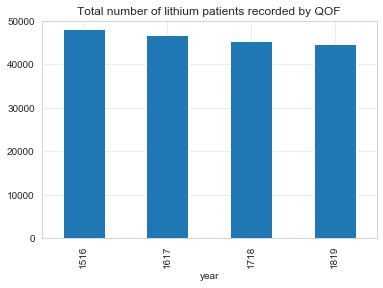

In [66]:
# Generate graph showing change in QOF patient numbers over time 
plot4 = df_qof1.groupby("year")["totalpts"].sum().plot(kind='bar', title="Total number of lithium patients recorded by QOF")
plt.ylim(0, 50000)

### Compare 2018/9 QOF data (no of lithium patients per practice) with Monthly Practice level data (no of lithium items dispensed per practice)

In [67]:
#First convert monthly practice level data into annual figures for 2018-2019

mask8 = (df_lithium['month'] >= "2018-04-01") & (df_lithium['month'] <= "2019-03-01")
df_annual1819 = df_lithium.loc[mask8]
df_annual1819.head()

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
684791,2018-04-01,D81012,06H,0402030K0,Lithium carbonate,35,0,35,56.35943
684792,2018-04-01,D81043,06H,0402030K0,Lithium carbonate,108,0,108,139.48941
684793,2018-04-01,D82032,26A,0402030P0,Lithium citrate,0,1,1,12.49509
684794,2018-04-01,J82135,99M,0402030K0,Lithium carbonate,15,0,15,27.99608
684795,2018-04-01,G85696,72Q,0402030K0,Lithium carbonate,12,0,12,109.85561


In [68]:
#Calculate annual 2018/9 figures using monthly practice data
df_MPD1819 = df_annual1819.groupby(["practice","pct"], as_index=False).sum()
df_MPD1819.head()

,practice,pct,carbonate,citrate,total_lithium,total_cost
0,A81001,16C,93,0,93,148.41468
1,A81002,16C,274,0,274,1731.83890
2,A81004,16C,31,0,31,42.12874
3,A81005,16C,120,0,120,688.79219
4,A81006,16C,261,0,261,865.08903


In [69]:
# Next refine QOF data to only include 1819 figures
mask9 = (df_qof1["year"] == 1819)
df_qof1819 = df_qof1.loc[mask9]
df_qof1819.head()

,year,practice_id,indicator,denominator,exceptions,totalpts
22034,1819,F85681,MH010,0,0.0,0.0
22035,1819,F85707,MH010,0,0.0,0.0
22036,1819,F85048,MH010,1,0.0,1.0
22037,1819,F85053,MH010,5,0.0,5.0
22038,1819,F85684,MH010,1,0.0,1.0


In [70]:
#merge annual 2018-9 QOF data with annual 2018-9 monthly practice data
df_1819 = pd.merge(df_MPD1819, df_qof1819, left_on='practice', right_on='practice_id')
df_1819.head()

,practice,pct,carbonate,citrate,total_lithium,total_cost,year,practice_id,indicator,denominator,exceptions,totalpts
0,A81001,16C,93,0,93,148.41468,1819,A81001,MH010,5,0.0,5.0
1,A81002,16C,274,0,274,1731.83890,1819,A81002,MH010,13,0.0,13.0
2,A81004,16C,31,0,31,42.12874,1819,A81004,MH010,2,0.0,2.0
3,A81005,16C,120,0,120,688.79219,1819,A81005,MH010,5,2.0,7.0
4,A81006,16C,261,0,261,865.08903,1819,A81006,MH010,11,3.0,14.0


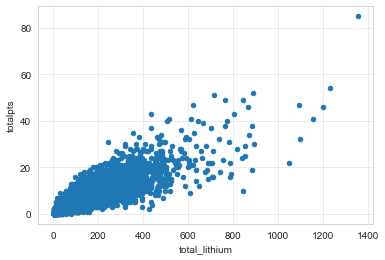

In [71]:
#SCATTER PLOT OF PRACTICE DATA - number of items dispensed against QOF recorded total lithium patients
#Note these are annual figures therefore each patient would have avg. 12 items if monthly dispensing.
plot5 = df_1819.plot.scatter("total_lithium", 'totalpts')

(0, 30)

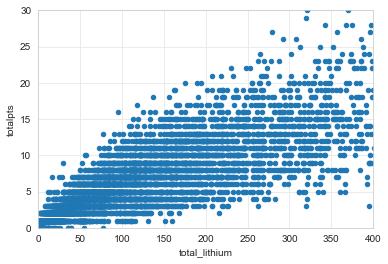

In [72]:
#zoom in on grouped data
plot6 = df_1819.plot.scatter("total_lithium", 'totalpts')
plt.xlim(0,400)
plt.ylim(0,30)

In [73]:
#group data according to PCT
df_1819PCT = df_1819.groupby(['pct']).sum().reset_index()
df_1819PCT.head()

,pct,carbonate,citrate,total_lithium,total_cost,year,denominator,exceptions,totalpts
0,00L,8564,46,8610,38595.25937,74579,321,28.0,349.0
1,00N,2320,43,2363,4319.00074,36380,78,12.0,90.0
2,00P,7991,52,8043,10340.50088,69122,181,17.0,198.0
3,00Q,2485,30,2515,4903.07859,38199,131,7.0,138.0
4,00R,2606,38,2644,5076.31352,30923,115,21.0,136.0


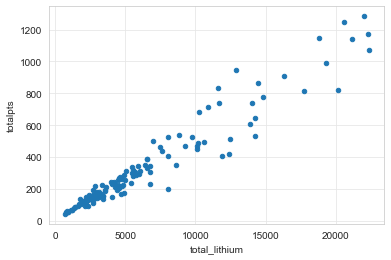

In [74]:
#SCATTER PLOT OF PCT DATA - number of items dispensed v no. of QOF recorded patients per PCT
plot7 = df_1819PCT.plot.scatter("total_lithium", 'totalpts')


In [75]:
sql6 = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
rx.practice,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "0402030K0%", items,0)) AS carbonate,
sum(IF(rx.bnf_code LIKE "0402030P0%", items,0)) AS citrate,
sum(items) AS total_lithium,
sum(actual_cost) AS total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practices AS prac
ON
rx.practice = prac.code 
JOIN
  hscic.ccgs AS ccgs
ON
rx.pct=ccgs.code
WHERE
  prac.setting != 4
  AND (bnf_code LIKE "0402030K0%" OR ##carbonate
  bnf_code LIKE "0402030P0%") ##citrate
  AND ccgs.org_type='CCG'
GROUP BY
rx.month,
rx.practice,
rx.pct,
chemical_code,
chemical
ORDER BY
month"""

df_nonGPlithium = bq.cached_read(sql6, csv_path='lithium.csv')

Downloading: 100%|██████████| 5811/5811 [00:00<00:00, 7493.23rows/s]


In [76]:
df_nonGPlithium.head()

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01 00:00:00+00:00,Y00890,00R,0402030K0,Lithium carbonate,1,0,1,0.46
1,2010-08-01 00:00:00+00:00,Y00656,13T,0402030K0,Lithium carbonate,1,0,1,0.15
2,2010-08-01 00:00:00+00:00,Y00781,08N,0402030K0,Lithium carbonate,1,0,1,1.76
3,2010-08-01 00:00:00+00:00,C85627,02P,0402030K0,Lithium carbonate,7,0,7,10.05
4,2010-08-01 00:00:00+00:00,C88075,03N,0402030K0,Lithium carbonate,3,0,3,1.89


In [77]:
df_nonGPlithium['month'] = df_nonGPlithium['month'].astype('datetime64[ns]')

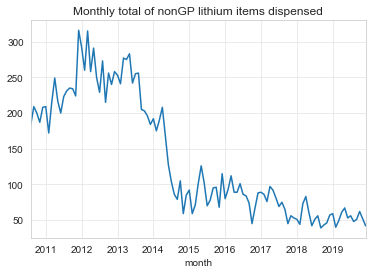

In [78]:
ot3 = df_nonGPlithium.groupby("month")['total_lithium'].sum().plot(kind='line', title="Monthly total of nonGP lithium items dispensed")